# Data

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # important!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

ModuleNotFoundError: No module named 'xgboost'

In [2]:
# df = pd.read_pickle('./drive/Msc_FYP/data/data_100.pickle')
# items = pd.read_pickle('./drive/Msc_FYP/data/fdump_100.pickle')

df = pd.read_pickle('data_100.pickle')
items = pd.read_pickle('fdump_100.pickle')
df = df.query('defined_target_vb200_vf3_volatility_VWAP_200 == 1')

In [3]:
feats_dict3 = {'gram':[c for c in df.columns if c.startswith('gram')],
              'pos':[c for c in df.columns if c.startswith('pos')],
              'title_tfidf':[c for c in df.columns if c.startswith('title_tfidf')],
              'source_bow':[c for c in df.columns if c.startswith('source_bow')],
              'Pre_Doc2Vec': [c for c in df.columns if c.startswith('Pre_Doc2Vec')],
              'pol_sub':[c for c in df.columns if c.startswith('polarity') | c.startswith('subje')],
              'tfidf':[c for c in df.columns if c.startswith('tfidf')]}

gram = feats_dict3['gram']
pos = feats_dict3['pos']
title = feats_dict3['title_tfidf']
source = feats_dict3['source_bow']
Doc2Vec = feats_dict3['Pre_Doc2Vec']
pol_sub = feats_dict3['pol_sub']
tfidf = feats_dict3['tfidf']

In [6]:
df.shape #(5193-3500=1693)

#[:3600] [3600:4630][4630:]

(3394, 971)

# Only nlp

## training functions


In [7]:
#-------------------------------------------------------------
def get_data(data, feats_col, target_col):

    X = data[feats_col].apply(np.float32)
   
    X = X.values
    targets = ['target_{}'.format(target_col)]
    targets_dataframe = df[targets]
    targets_dataframe[targets] = np.where(targets_dataframe[targets]!=-1,targets_dataframe[targets],float(2))
    y = targets_dataframe.values
    
    c, r = y.shape
    y = y.reshape(c,)
    
    
    return X, y
  

#-------------------------------------------------------------
# -------------------------------------------------------------
def cv_generator(n_cv):
    
    N = 2758 #4089 [0:3600] [3600:4630] [4630:]
    
    n_train = int(np.floor(N/(1+0.3*n_cv)))
    n_test = int(np.floor(0.3*n_train))
    
    for cv_idx in range(n_cv):
        
        train_idx = [i for i in range(cv_idx*n_test, cv_idx*n_test +n_train)] 
        test_idx = [i for i in range(cv_idx*n_test +n_train, (cv_idx+1)*n_test +n_train)] 
        
        yield (train_idx, test_idx)
        
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from scipy import interp
def AUC(y_true,y_probas):
    
#     print(y_probas)
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)


    classes = np.unique(y_true)
    probas = y_probas

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true, probas[:, i],
                                      pos_label=classes[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    average_score = (roc_auc[1]+roc_auc[2])/2
    return average_score
  
  
  
  
  
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from scipy import interp

title_fontsize="small"
text_fontsize="small"
curves=('micro', 'macro', 'each_class')
cmap='nipy_spectral'


def plot_AUC(true_y,predict,title):


    plt.figure()
    y_true = true_y
    y_probas = predict
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    if 'micro' not in curves and 'macro' not in curves and \
            'each_class' not in curves:
        raise ValueError('Invalid argument for curves as it '
                         'only takes "micro", "macro", or "each_class"')

    classes = np.unique(y_true)
    probas = y_probas

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true, probas[:, i],
                                      pos_label=classes[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
       

    # Compute micro-average ROC curve and ROC area
    micro_key = 'micro'
    i = 0
    while micro_key in fpr:
        i += 1
        micro_key += str(i)

    y_true = label_binarize(y_true, classes=classes)
    if len(classes) == 2:
        y_true = np.hstack((1 - y_true, y_true))

    fpr[micro_key], tpr[micro_key], _ = roc_curve(y_true.ravel(),
                                                  probas.ravel())
    roc_auc[micro_key] = auc(fpr[micro_key], tpr[micro_key])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[x] for x in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    macro_key = 'macro'
    i = 0
    while macro_key in fpr:
        i += 1
        macro_key += str(i)
    fpr[macro_key] = all_fpr
    tpr[macro_key] = mean_tpr
    roc_auc[macro_key] = auc(fpr[macro_key], tpr[macro_key])
   

    title = title
    plt.title(title, fontsize=title_fontsize)

#         if 'each_class' in curves:
    for i in range(len(classes)):
        color = plt.cm.get_cmap(cmap)(float(i) / len(classes))
        plt.plot(fpr[i], tpr[i], lw=2, color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes[i], roc_auc[i]))

#         if 'micro' in curves:
    plt.plot(fpr[micro_key], tpr[micro_key],
            label='micro-average ROC curve '
                  '(area = {0:0.2f})'.format(roc_auc[micro_key]),
            color='deeppink', linestyle=':', linewidth=4)

#         if 'macro' in curves:
    plt.plot(fpr[macro_key], tpr[macro_key],
            label='macro-average ROC curve '
                  '(area = {0:0.2f})'.format(roc_auc[macro_key]),
            color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=text_fontsize)
    plt.ylabel('True Positive Rate', fontsize=text_fontsize)
    plt.tick_params(labelsize=text_fontsize)
    plt.legend(loc='lower right', fontsize=text_fontsize)
    plt.show()


## single nlp

In [7]:
output_dict3={}

feats_dict3 = {'gram':[c for c in df.columns if c.startswith('gram')],
              'pos':[c for c in df.columns if c.startswith('pos')],
              'title_tfidf':[c for c in df.columns if c.startswith('title_tfidf')],
              'source_bow':[c for c in df.columns if c.startswith('source_bow')],
              'Pre_Doc2Vec': [c for c in df.columns if c.startswith('Pre_Doc2Vec')],
              'pol_sub':[c for c in df.columns if c.startswith('polarity') | c.startswith('subje')],
              'tfidf':[c for c in df.columns if c.startswith('tfidf')]}

AUC_score = make_scorer(AUC, greater_is_better=True, needs_proba = True)
scoring = {'AUC': AUC_score}


target_cols = 'vb200_vf3_volatility_VWAP_200'
i = 0
for feats_key, feats_col in feats_dict3.items():                

    i+=1

    X, y = get_data(df, feats_col, target_cols)

    #XGBOOST()
    fit_params={"early_stopping_rounds":5, 
                "eval_metric" : "mlogloss", 
                "eval_set" : [(X[2758:], y[2758:])],
                "verbose":5}
    cv = cv_generator(2)

    gs = GridSearchCV(XGBClassifier(objective= 'multi:softprob'),
                      param_grid={
                                  'learning_rate':[0.3],
                                 },
                      scoring= scoring,
                      cv = cv,
                      n_jobs=10,
                      verbose=1,
                      fit_params = fit_params,
                      refit= 'AUC') #


    gs.fit(X, y)
    output_dict3['model_{}'.format(i)] = {'target':target_cols, 'feats':feats_key, 'GridObject':gs}

     
        
        

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[0]	validation_0-mlogloss:1.09508
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[0]	validation_0-mlogloss:1.09398
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[5]	validation_0-mlogloss:1.09959
[5]	validation_0-mlogloss:1.09434
Stopping. Best iteration:
[1]	validation_0-mlogloss:1.09247

Stopping. Best iteration:
[2]	validation_0-mlogloss:1.09384



[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    1.7s finished


[0]	validation_0-mlogloss:1.09234
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[5]	validation_0-mlogloss:1.08509
[10]	validation_0-mlogloss:1.08322
[15]	validation_0-mlogloss:1.08022
[20]	validation_0-mlogloss:1.07751
[25]	validation_0-mlogloss:1.07517
[30]	validation_0-mlogloss:1.07283
[35]	validation_0-mlogloss:1.07155
[40]	validation_0-mlogloss:1.07029
[45]	validation_0-mlogloss:1.06852
[50]	validation_0-mlogloss:1.06684
[55]	validation_0-mlogloss:1.06549
[60]	validation_0-mlogloss:1.06392
[65]	validation_0-mlogloss:1.06296
[70]	validation_0-mlogloss:1.06172
[75]	validation_0-mlogloss:1.06063
[80]	validation_0-mlogloss:1.0599
[85]	validation_0-mlogloss:1.05857
[90]	validation_0-mlogloss:1.05776
[95]	validation_0-mlogloss:1.05688
[99]	validation_0-mlogloss:1.0562


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationW

[0]	validation_0-mlogloss:1.09398
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[0]	validation_0-mlogloss:1.09844
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[5]	validation_0-mlogloss:1.1027
Stopping. Best iteration:
[0]	validation_0-mlogloss:1.09398

[5]	validation_0-mlogloss:1.1113
Stopping. Best iteration:
[0]	validation_0-mlogloss:1.09844



[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    1.6s finished


[0]	validation_0-mlogloss:1.0857
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[5]	validation_0-mlogloss:1.04846
[10]	validation_0-mlogloss:1.02327
[15]	validation_0-mlogloss:1.00382
[20]	validation_0-mlogloss:0.985582
[25]	validation_0-mlogloss:0.970473
[30]	validation_0-mlogloss:0.953855
[35]	validation_0-mlogloss:0.941128
[40]	validation_0-mlogloss:0.926507
[45]	validation_0-mlogloss:0.908555
[50]	validation_0-mlogloss:0.897856
[55]	validation_0-mlogloss:0.884532
[60]	validation_0-mlogloss:0.869769
[65]	validation_0-mlogloss:0.857075
[70]	validation_0-mlogloss:0.842486
[75]	validation_0-mlogloss:0.834564
[80]	validation_0-mlogloss:0.824393
[85]	validation_0-mlogloss:0.812246
[90]	validation_0-mlogloss:0.801802
[95]	validation_0-mlogloss:0.789558
[99]	validation_0-mlogloss:0.782049


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


[0]	validation_0-mlogloss:1.09756
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[5]	validation_0-mlogloss:1.12185
Stopping. Best iteration:
[0]	validation_0-mlogloss:1.09756

[0]	validation_0-mlogloss:1.0982
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[5]	validation_0-mlogloss:1.12085
Stopping. Best iteration:
[0]	validation_0-mlogloss:1.0982



[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    0.4s finished


[0]	validation_0-mlogloss:1.08966
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[5]	validation_0-mlogloss:1.07989
[10]	validation_0-mlogloss:1.07802
[15]	validation_0-mlogloss:1.07708
[20]	validation_0-mlogloss:1.07691
[25]	validation_0-mlogloss:1.07644
[30]	validation_0-mlogloss:1.07592
[35]	validation_0-mlogloss:1.07621
Stopping. Best iteration:
[30]	validation_0-mlogloss:1.07592



/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


[0]	validation_0-mlogloss:1.09411
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[0]	validation_0-mlogloss:1.0965
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[5]	validation_0-mlogloss:1.09796
Stopping. Best iteration:
[1]	validation_0-mlogloss:1.09345

[5]	validation_0-mlogloss:1.10945
Stopping. Best iteration:
[0]	validation_0-mlogloss:1.0965



[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    1.5s finished


[0]	validation_0-mlogloss:1.0929
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[5]	validation_0-mlogloss:1.08651
[10]	validation_0-mlogloss:1.08503
[15]	validation_0-mlogloss:1.08451
[20]	validation_0-mlogloss:1.08346
[25]	validation_0-mlogloss:1.08169
[30]	validation_0-mlogloss:1.081
[35]	validation_0-mlogloss:1.08012
[40]	validation_0-mlogloss:1.07927
[45]	validation_0-mlogloss:1.07858
[50]	validation_0-mlogloss:1.0783
[55

limit_output extension: Maximum message size of 10000 exceeded with 10032 characters

### result_1

In [8]:
output_3 = pd.DataFrame.from_dict(output_dict3, orient='index')
# train['word_count'] = train['content'].apply(lambda x: len(str(x).split(" ")))
output_3['para']=output_3['GridObject'].apply(lambda x: x.best_params_ )
output_3['score']=output_3['GridObject'].apply(lambda x: x.best_score_ )

output_3


,target,feats,GridObject,para,score
model_1,vb200_vf3_volatility_VWAP_200,gram,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.495994
model_2,vb200_vf3_volatility_VWAP_200,pos,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.480447
model_3,vb200_vf3_volatility_VWAP_200,title_tfidf,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.481885
model_4,vb200_vf3_volatility_VWAP_200,source_bow,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.483124
model_5,vb200_vf3_volatility_VWAP_200,Pre_Doc2Vec,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.490128
model_6,vb200_vf3_volatility_VWAP_200,pol_sub,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.501099
model_7,vb200_vf3_volatility_VWAP_200,tfidf,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.504475


## hyper-parameter, many nlp

In [7]:
#----------------------------------------
def precision(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    average_precision = {}
    for i in range(len(classes)):
        average_precision[i] = average_precision_score(y_true[:, i], probas[:, i])
        
    ave_precision = (average_precision[1]+average_precision[2])/2

    return ave_precision
    
def recall(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    recall = {}
    for i in range(len(classes)):
        recall[i] = recall_score(y_true[:, i], probas[:, i].round())
        
    ave_recall = (recall[1]+recall[2])/2

    return ave_recall


def accuracy(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    acc = {}
    for i in range(len(classes)):
        acc[i] = accuracy_score(y_true[:, i], probas[:, i].round())
        
    ave_acc = (acc[1]+acc[2])/2
    
    return ave_acc

In [8]:
def get_data(data, feats_col, target_col):
    
    X = data[feats_col].apply(np.float32)
    X = X.values
    targets = ['target_{}'.format(target_col)]
    targets_dataframe = df[targets]
    targets_dataframe[targets] = np.where(targets_dataframe[targets]!=-1,targets_dataframe[targets],float(2))
    y = targets_dataframe.values
    
    c, r = y.shape
    y = y.reshape(c,)
    
    
    return X, y
  
# ++  tfidf+pol_sub+gram+Doc2Vec+source+title+pos
feats_com = [tfidf,tfidf+pol_sub,tfidf+pol_sub+gram,
            tfidf+pol_sub+gram+Doc2Vec+source,
            tfidf+pol_sub+gram+Doc2Vec+source+title+pos]

output_dict3={}

AUC_score = make_scorer(AUC, greater_is_better=True, needs_proba = True)
_precision_score = make_scorer(precision, greater_is_better=True, needs_proba = True)
_recall_score = make_scorer(recall, greater_is_better=True, needs_proba = True)
_accuracy_score = make_scorer(accuracy, greater_is_better=True, needs_proba = True)

scoring = {'AUC': AUC_score,'precision':_precision_score,'recall':_recall_score,'accuracy':_accuracy_score}

learning_rate = [[2.2],[2.0],[0.8],[2.6],[3.4]]
n_estimators = [[150],[400],[350],[200],[800]]
max_depth = [[3],[2],[3],[4],[3]]
min_child_weight = [[3],[1],[1],[1],[1]]
gamma = [[0.3],[0],[0.2],[0.4],[0]]
subsample = [[0.9],[1],[1],[1],[1]]
bytree = [[0.6],[1],[1],[1],[1]]
reg_alpha = [[0.005],[0.001],[0],[0],[0]]


target_cols = 'vb200_vf3_volatility_VWAP_200'
for i in range(5):
    
    feature = feats_com[i]
    X, y = get_data(df, feature, target_cols)
    cv = cv_generator(1)

    xgb = XGBClassifier(
                         objective= 'multi:softprob',
                        )


    gs = GridSearchCV(xgb,
                      param_grid={
                                  'learning_rate':learning_rate[i],
                                  'n_estimators':n_estimators[i],
                                  'max_depth':max_depth[i],
                                  'min_child_weight':min_child_weight[i],
                                  'gamma':gamma[i],
                                  'subsample':subsample[i],
                                  'colsample_bytree':bytree[i],
                                  'reg_alpha':reg_alpha[i]
                                 },
                      scoring= scoring,
                      cv = cv,
                      n_jobs=10,
                      verbose=1,
                      refit='AUC')


    gs.fit(X[:2758], y[:2758])
    output_dict3['model_{}'.format(i+1)] = {'target':target_cols,'GridObject':gs}

        
        

Fitting 1 folds for each of 1 candidates, totalling 1 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

Fitting 1 folds for each of 1 candidates, totalling 1 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

Fitting 1 folds for each of 1 candidates, totalling 1 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

Fitting 1 folds for each of 1 candidates, totalling 1 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

Fitting 1 folds for each of 1 candidates, totalling 1 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

### results

In [9]:
output_3 = pd.DataFrame.from_dict(output_dict3, orient='index')
# train['word_count'] = train['content'].apply(lambda x: len(str(x).split(" ")))
output_3['para']=output_3['GridObject'].apply(lambda x: x.best_params_ )
output_3['score']=output_3['GridObject'].apply(lambda x: x.best_score_ )
output_3['Accuracy']=output_3['GridObject'].apply(lambda x: x.cv_results_['mean_test_accuracy'][0])
output_3['Recall']=output_3['GridObject'].apply(lambda x: x.cv_results_['mean_test_recall'][0])
output_3['precision']=output_3['GridObject'].apply(lambda x: x.cv_results_['mean_test_precision'][0])
output_3



,target,GridObject,para,score,Accuracy,Recall,precision
model_1,vb200_vf3_volatility_VWAP_200,GridSearchCV(cv=<generator object cv_generator...,"{'colsample_bytree': 0.6, 'gamma': 0.3, 'learn...",0.528094,0.635220,0.244065,0.297781
model_2,vb200_vf3_volatility_VWAP_200,GridSearchCV(cv=<generator object cv_generator...,"{'colsample_bytree': 1, 'gamma': 0, 'learning_...",0.515286,0.635220,0.238381,0.296441
model_3,vb200_vf3_volatility_VWAP_200,GridSearchCV(cv=<generator object cv_generator...,"{'colsample_bytree': 1, 'gamma': 0.2, 'learnin...",0.515268,0.683962,0.110195,0.303962
model_4,vb200_vf3_volatility_VWAP_200,GridSearchCV(cv=<generator object cv_generator...,"{'colsample_bytree': 1, 'gamma': 0.4, 'learnin...",0.531276,0.636792,0.269303,0.295779
model_5,vb200_vf3_volatility_VWAP_200,GridSearchCV(cv=<generator object cv_generator...,"{'colsample_bytree': 1, 'gamma': 0, 'learning_...",0.533144,0.634434,0.306972,0.299377


In [10]:
# 
models = []
for i in range(5):
    models.append(output_3['GridObject'].iloc[i].best_estimator_)
models

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.6, gamma=0.3, learning_rate=2.2,
        max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
        n_estimators=150, n_jobs=1, nthread=None,
        objective='multi:softprob', random_state=0, reg_alpha=0.005,
        reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
        subsample=0.9),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=2.0, max_delta_step=0,
        max_depth=2, min_child_weight=1, missing=None, n_estimators=400,
        n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
        reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0.2, learning_rate=0.8, max_delta_step=0,
        max_depth=3, min_child_weight=1, mis

In [34]:
# !!!!!!!!!!!!!
output_3['para'].tolist()

[{'colsample_bytree': 0.6,
  'gamma': 0.3,
  'learning_rate': 2.2,
  'max_depth': 3,
  'min_child_weight': 3,
  'n_estimators': 150,
  'reg_alpha': 0.005,
  'subsample': 0.9},
 {'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 2.0,
  'max_depth': 2,
  'min_child_weight': 1,
  'n_estimators': 400,
  'reg_alpha': 0.001,
  'subsample': 1},
 {'colsample_bytree': 1,
  'gamma': 0.2,
  'learning_rate': 0.8,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 350,
  'reg_alpha': 0,
  'subsample': 1},
 {'colsample_bytree': 1,
  'gamma': 0.4,
  'learning_rate': 2.6,
  'max_depth': 4,
  'min_child_weight': 1,
  'n_estimators': 200,
  'reg_alpha': 0,
  'subsample': 1},
 {'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 3.4,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 800,
  'reg_alpha': 0,
  'subsample': 1}]

### testing result -- plots

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

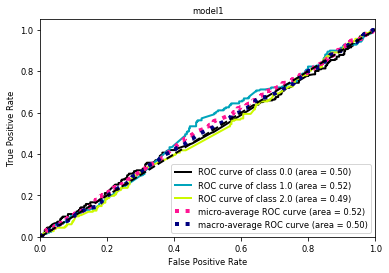

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

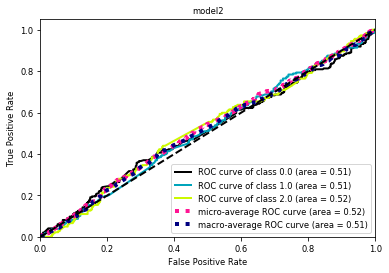

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

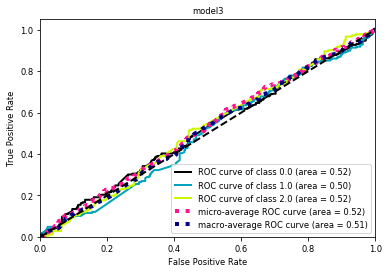

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

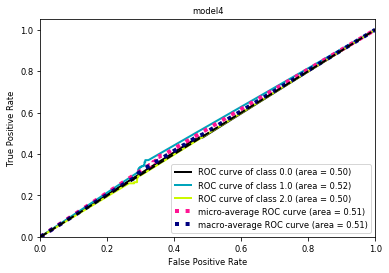

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

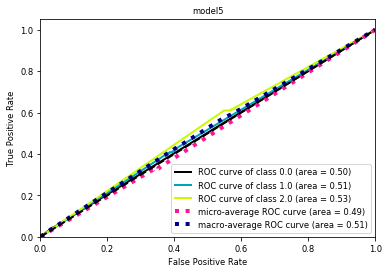

In [11]:
for i in range(5):
#     gs = output_3['GridObject'].iloc[i]
#     best = gs.best_estimator_
#   print(best)
    best = models[i]
    feats = feats_com[i]
    X,y = get_data(df, feats, 'vb200_vf3_volatility_VWAP_200')
    best.fit(X[:2758],y[:2758],sample_weight = df['sample_weights_vb200_vf3_volatility_VWAP_200'][:2758])
#   print('AUC_{}'.format(i+1), AUC(y[-818:],best.predict_proba(X[-818:])))
    plot_AUC(y[2758:],best.predict_proba(X[2758:]),'model{}'.format(i+1))
#     print(best.predict_proba(X[2758:]))
  
#   gs.cv_results_['mean_train_AUC']

In [0]:
for c in ['target_vb50_vf2_volatility_VWAP_200','target_vb50_vf3_volatility_VWAP_200','target_vb100_vf2_volatility_VWAP_200','target_vb100_vf3_volatility_VWAP_200','target_vb200_vf2_volatility_VWAP_200','target_vb200_vf3_volatility_VWAP_200']:
    print(df[[c, c.replace('target', 'futureReturn')]].groupby(c).describe()[c.replace('target', 'futureReturn')][['count', 'mean']])

                                      count      mean
target_vb50_vf2_volatility_VWAP_200                  
-1.0                                  565.0 -0.003367
 0.0                                 4052.0 -0.000021
 1.0                                  576.0  0.003335
                                      count      mean
target_vb50_vf3_volatility_VWAP_200                  
-1.0                                  244.0 -0.004437
 0.0                                 4719.0 -0.000021
 1.0                                  230.0  0.004473
                                       count      mean
target_vb100_vf2_volatility_VWAP_200                  
-1.0                                  1007.0 -0.003694
 0.0                                  3201.0 -0.000003
 1.0                                   985.0  0.003747
                                       count      mean
target_vb100_vf3_volatility_VWAP_200                  
-1.0                                   539.0 -0.004896
 0.0                

### dataframe

In [12]:
gs = output_3['GridObject'].iloc[0]
best = gs.best_estimator_
feats = feats_com[0]
X,y = get_data(df, feats, 'vb200_vf3_volatility_VWAP_200')
prediction_df = pd.DataFrame(best.predict_proba(X[2758:]),columns = ['idel_1','buy_1','sell_1']).reset_index()

for i in range(1,5):
#     gs = output_3['GridObject'].iloc[i]
#     best = gs.best_estimator_
    best = models[i]
    feats = feats_com[i]
    X,y = get_data(df, feats, 'vb200_vf3_volatility_VWAP_200')
    best.fit(X[:2758],y[:2758],sample_weight = df['sample_weights_vb200_vf3_volatility_VWAP_200'][:2758])
    predictions = pd.DataFrame(best.predict_proba(X[2758:]),
                                 columns = ['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)])
    prediction_df = pd.merge(prediction_df,predictions,left_index=True,right_index= True)
    
true = pd.DataFrame(y[2758:],columns = ['true_value'])
prediction_df['true_value'] = true['true_value'] #idle
# prediction_df

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [13]:
prediction_df.to_pickle('prediction_df_2.pkl')

### accuracy

In [72]:
auc_score_list = []
accuracy_list = []
for i in range(5):
    gs = output_3['GridObject'].iloc[i]
    best = gs.best_estimator_
#   print(best)
    feats = feats_com[i]
    X,y = get_data(df, feats, 'vb200_vf3_volatility_VWAP_200')
#   print('AUC_{}'.format(i+1), AUC(y[-818:],best.predict_proba(X[-818:])))
    accuracy_list.append(accuracy_score(y[4150:],best.predict(X[4150:])))
    auc_score_list.append(AUC(y[4150:],best.predict_proba(X[4150:])))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [65]:
print(auc_score_list)
print(accuracy_list)

[0.6557849856965678, 0.6050175475589706, 0.5922317870363898, 0.6077936562017101, 0.6093046267937392]
[0.5992329817833174, 0.5743048897411314, 0.5580057526366251, 0.5973154362416108, 0.5944391179290508]


## Contains Market

In [14]:
## Model conbinations
from xgboost import plot_importance
market_feats = items['all_feats'][:189]
for i in range(5):
#     gs = output_3['GridObject'].iloc[i]
#     model = gs.best_estimator_
#     feats = feats_com[i]
    model = models[i]
    X,y = get_data(df,market_feats,'vb200_vf3_volatility_VWAP_200')
    model.fit(X[2758:], y[2758:],sample_weight = df['sample_weights_vb200_vf3_volatility_VWAP_200'][:2758])
    features_name = list(df[market_feats].columns.values)
    feature_importance = list(zip(features_name, model.feature_importances_))
    data = pd.DataFrame(feature_importance,columns=['feature','importance'])
    data.to_csv('./Target_Two/market_importance_model{}.csv'.format(i+1))


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

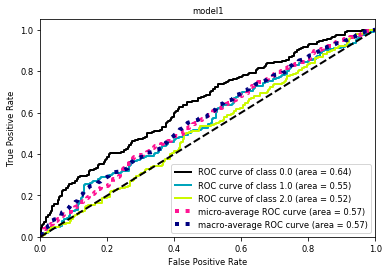

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

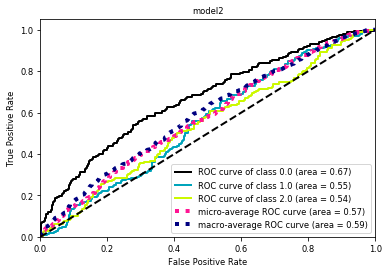

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

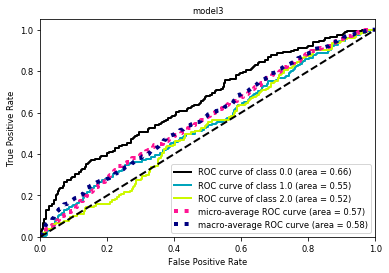

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

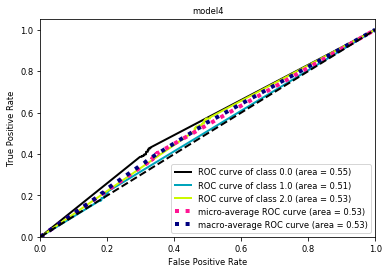

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

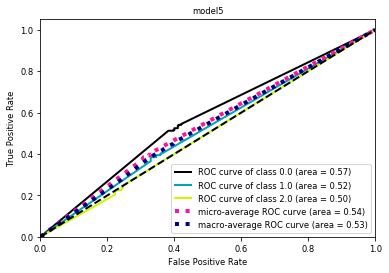

In [15]:
## pick important market features
accuracy_list = []
auc_score_list = []
for i in range(5):
#     gs = output_3['GridObject'].iloc[i]
#     model = gs.best_estimator_
    model = models[i]
    market_feats = pd.read_csv('./Target_Two/market_importance_model{}.csv'.format(i+1))['feature'].tolist()[:20]
    feats = feats_com[i] + market_feats
    X,y = get_data(df, feats, 'vb200_vf3_volatility_VWAP_200')
    model.fit(X[:2758],y[:2758],sample_weight = df['sample_weights_vb200_vf3_volatility_VWAP_200'][:2758])
    y_true = y[2758:]
    y_probas = model.predict_proba(X[2758:])
    y_predict = model.predict(X[2758:])
    
    plot_AUC(y_true,y_probas,'model{}'.format(i+1))
    accuracy_list.append(accuracy_score(y_true,y_predict))
    auc_score_list.append(AUC(y_true,y_probas))
    
    if i == 0:
        prediction_df = pd.DataFrame(y_probas,
                                     columns = ['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)])
    else:
        predictions =  pd.DataFrame(y_probas,
                                     columns = ['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)])
        prediction_df = pd.merge(prediction_df,predictions,left_index=True,right_index= True)

true = pd.DataFrame(y[2758:],columns = ['true_value'])
prediction_df['true_value'] = true['true_value'] #idle
prediction_df.to_pickle('prediction_df_market2.pkl')

In [17]:
market_feats = items['all_feats'][:189]
for i in range(5):
#     gs = output_3['GridObject'].iloc[i]
    model = models[i]
    feats = feats_com[i] + market_feats
    X,y = get_data(df, feats, 'vb200_vf3_volatility_VWAP_200')
    model.fit(X[:2758],y[:2758],sample_weight = df['sample_weights_vb200_vf3_volatility_VWAP_200'][:2758])
    y_true = y[2758:]
    y_probas = model.predict_proba(X[2758:])
    y_predict = model.predict(X[2758:])
    
#     plot_AUC(y_true,y_probas,'model{}'.format(i+1))
#     accuracy_list.append(accuracy_score(y_true,y_predict))
#     auc_score_list.append(AUC(y_true,y_probas))
    
    if i == 0:
        prediction_df = pd.DataFrame(y_probas,
                                     columns = ['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)])
    else:
        predictions =  pd.DataFrame(y_probas,
                                     columns = ['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)])
        prediction_df = pd.merge(prediction_df,predictions,left_index=True,right_index= True)

true = pd.DataFrame(y[2758:],columns = ['true_value'])
prediction_df['true_value'] = true['true_value'] #idle
prediction_df.to_pickle('prediction_df_all2.pkl')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [9]:
feats_com = [tfidf,tfidf+pol_sub,tfidf+pol_sub+gram,
            tfidf+pol_sub+gram+Doc2Vec+source,
            tfidf+pol_sub+gram+Doc2Vec+source+title+pos]



from sklearn.dummy import DummyClassifier




stra = "stratified"
feats = feats_com[4]
X,y = get_data(df, feats, 'vb200_vf3_volatility_VWAP_200')
clf = DummyClassifier(strategy=stra, random_state=0)
clf = clf.fit(X[:2758], y[:2758])
y_probas = clf.predict_proba(X[2758:])
predictions1 =  pd.DataFrame(y_probas,
                            columns = 
                            ['idel_nlp','buy_nlp','sell_nlp'])
true = pd.DataFrame(y[2758:],columns = ['true_value'])
predictions1['true_value'] = true['true_value']
predictions1.to_pickle('./Dummy/prediction_dummy_nlp1.pkl')


feats = feats_com[1] + items['all_feats'][:189]
X,y = get_data(df, feats, 'vb200_vf3_volatility_VWAP_200')
clf = DummyClassifier(strategy=stra, random_state=0)
clf = clf.fit(X[:2758], y[:2758])
y_probas = clf.predict_proba(X[2758:])
predictions2 =  pd.DataFrame(y_probas,
                            columns = 
                            ['idel_all','buy_all','sell_all'])
true = pd.DataFrame(y[2758:],columns = ['true_value'])
predictions2['true_value'] = true['true_value']
predictions2.to_pickle('./Dummy/prediction_dummy_all1.pkl')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu